In [1]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
#!pip install session-info

In [3]:
import session_info
session_info.show()

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:54:10_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.relgpu_drvr455TC455_06.29190527_0


In [5]:
torch.cuda.is_available()

True

In [6]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([
        
                      transforms.Resize((224,224)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    
    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset = torch.utils.data.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=DataLoader(train_dataset,batch_size,shuffle=True)
    data_loader_test=DataLoader(test_dataset,batch_size,shuffle=False)
    data_loader_val=DataLoader(val_dataset,batch_size,shuffle=False)  
    return data_loader_train, data_loader_test, data_loader_val

In [7]:
train_loader,test_loader,val_loader=load_data(path=r'D:/SupraAI Project/BinarySplit/', 
                                              test_split=0.1,val_split= 0.1,batch_size=16, input_size=[224,224])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 23706 samples in 0.293s...
[t-SNE] Computed neighbors for 23706 samples in 132.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23706
[t-SNE] Computed conditional probabilities for sample 2000 / 23706
[t-SNE] Computed conditional probabilities for sample 3000 / 23706
[t-SNE] Computed conditional probabilities for sample 4000 / 23706
[t-SNE] Computed conditional probabilities for sample 5000 / 23706
[t-SNE] Computed conditional probabilities for sample 6000 / 23706
[t-SNE] Computed conditional probabilities for sample 7000 / 23706
[t-SNE] Computed conditional probabilities for sample 8000 / 23706
[t-SNE] Computed conditional probabilities for sample 9000 / 23706
[t-SNE] Computed conditional probabilities for sample 10000 / 23706
[t-SNE] Computed conditional probabilities for sample 11000 / 23706
[t-SNE] Computed conditional probabilities for sample 12000 / 23706
[t-SNE] Computed conditional probabilities for 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


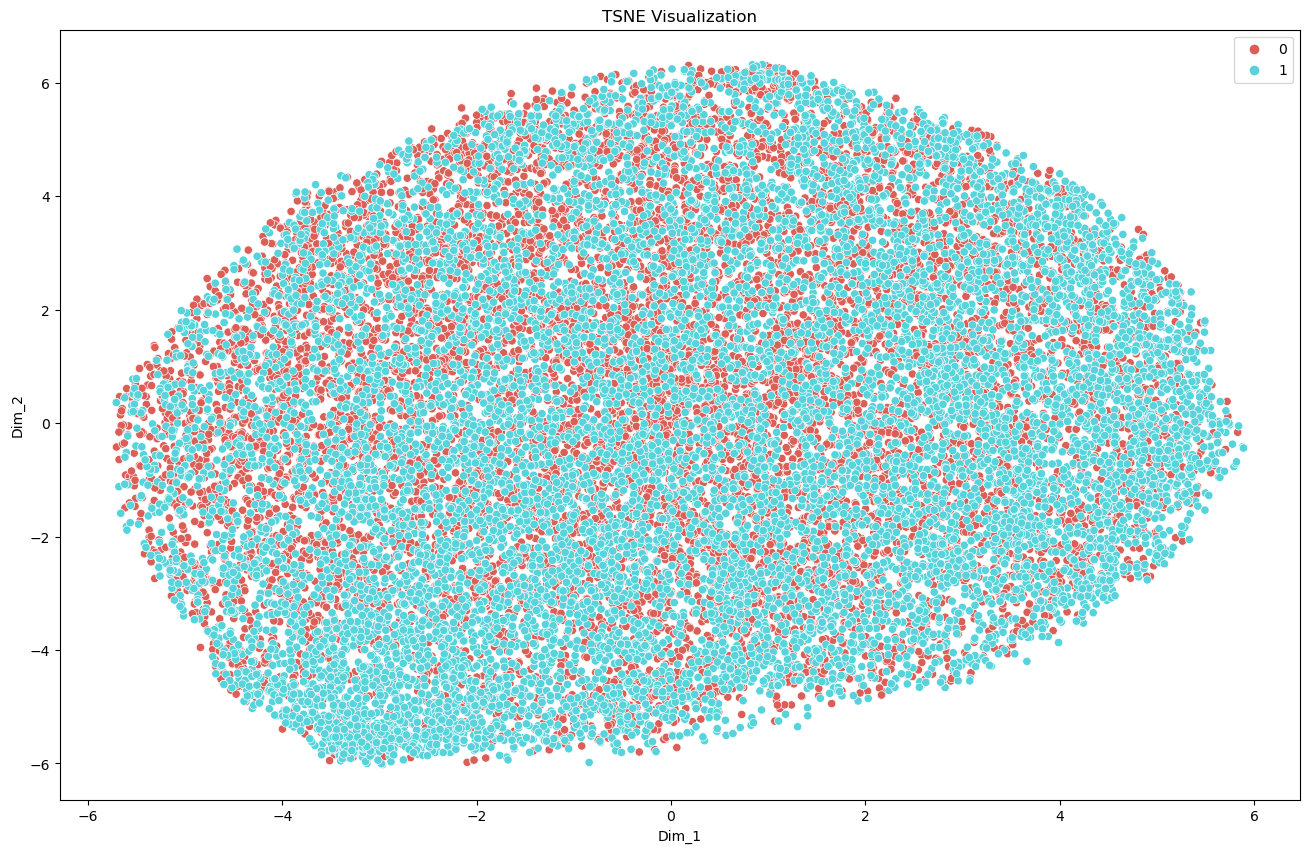

In [8]:
data=datasets.ImageFolder(root=r'D:/SupraAI Project/BinarySplit/')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 2),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()

In [8]:
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False, num_classes = 2)


optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Try to drop
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [9]:
num_epochs = 50
train_losses = []
train_accs = []
val_accs = []
val_losses = []


# patience = 15
# delta = 0.0001 
# best_val_loss = float('inf')
# best_model_state_dict = None
# counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

#         if val_loss < best_val_loss - delta: # validation loss improvement
#             best_val_loss = val_loss
#             best_model_state_dict = model.state_dict()
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print("Validation loss hasn't improved for {} epochs. Stopping early.".format(patience))
#                 break


# model.load_state_dict(best_model_state_dict) #Load the best model to eval on test

Epoch 1/50, Train Loss: 0.6622, Train Accuracy: 62.51%, Validation Loss: 0.0365, Validation Accuracy: 69.70%
Epoch 2/50, Train Loss: 0.5648, Train Accuracy: 70.91%, Validation Loss: 0.0299, Validation Accuracy: 77.72%
Epoch 3/50, Train Loss: 0.5171, Train Accuracy: 73.98%, Validation Loss: 0.0296, Validation Accuracy: 76.62%
Epoch 4/50, Train Loss: 0.4986, Train Accuracy: 75.34%, Validation Loss: 0.0310, Validation Accuracy: 75.40%
Epoch 5/50, Train Loss: 0.4896, Train Accuracy: 75.94%, Validation Loss: 0.0282, Validation Accuracy: 78.48%
Epoch 6/50, Train Loss: 0.4836, Train Accuracy: 76.26%, Validation Loss: 0.0278, Validation Accuracy: 78.52%
Epoch 7/50, Train Loss: 0.4800, Train Accuracy: 76.29%, Validation Loss: 0.0286, Validation Accuracy: 78.27%
Epoch 8/50, Train Loss: 0.4685, Train Accuracy: 77.05%, Validation Loss: 0.0261, Validation Accuracy: 79.32%
Epoch 9/50, Train Loss: 0.4662, Train Accuracy: 77.23%, Validation Loss: 0.0273, Validation Accuracy: 80.25%
Epoch 10/50, Train 

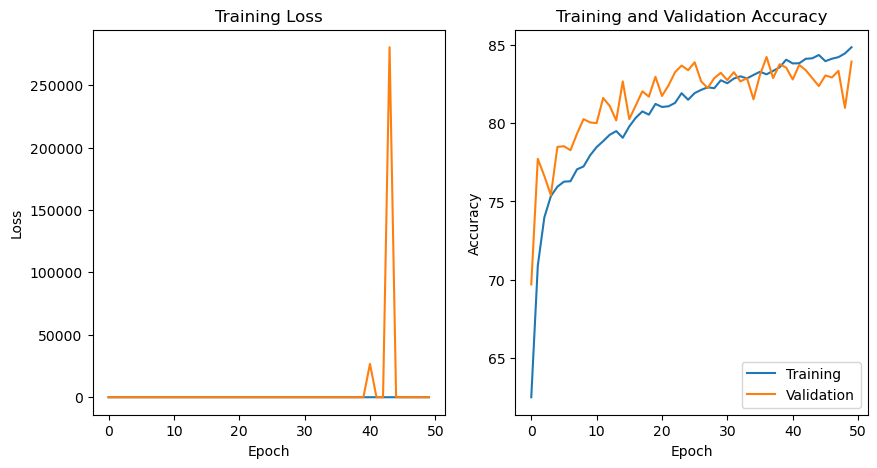

In [10]:
# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Training')
plt.plot(val_losses, label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [11]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())  # Predicted probabilities for all classes

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}')
# Save the model
torch.save(model.state_dict(), 'UTKFaceBiranyClassificationRShuffleNet.pth')

Test Accuracy: 82.9113924050633


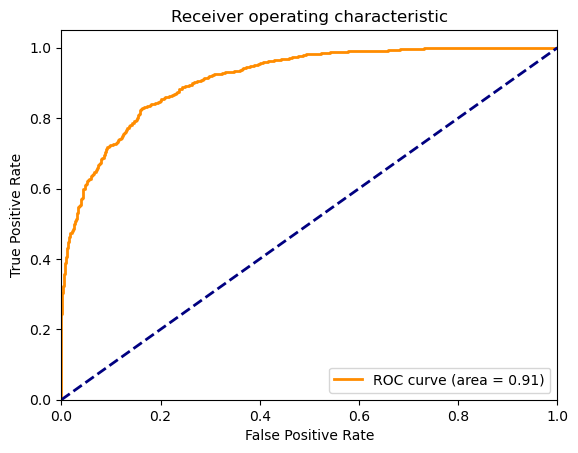

In [12]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Use the first column of y_pred as the predicted probabilities
y_pred = y_pred[:, 1]

# Reshape y_true to match the shape of y_pred
y_true = y_true.reshape(y_pred.shape)

# Calculate ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


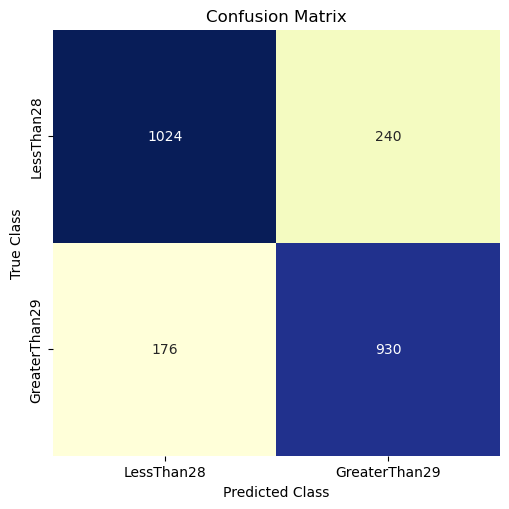

In [13]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('LessThan28', 'GreaterThan29')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(5, 5))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()